In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
# Read sensor_1_combined_data.xlsx and extract required columns
sensor_file = 'data/sensor_1_combined_data.xlsx'
df_sensor = pd.read_excel(sensor_file)

print("Sensor data columns:")
print(df_sensor.columns.tolist())
print("\nFirst few rows:")
print(df_sensor.head())
print("\nData shape:", df_sensor.shape)


Sensor data columns:
['datetime', 'upper_humidity', 'upper_temp_F', 'upper_irradiance_W_per_m2', 'sensor_id', 'power_W']

First few rows:
             datetime  upper_humidity  upper_temp_F  \
0 2025-08-12 17:10:00           46.08         95.05   
1 2025-08-12 17:20:00           46.93         94.09   
2 2025-08-12 17:30:00           50.45         92.09   
3 2025-08-12 17:40:00           57.89         88.96   
4 2025-08-12 17:50:00           60.97         87.62   

   upper_irradiance_W_per_m2  sensor_id  power_W  
0                     177.35          1  6440.61  
1                     157.30          1  5947.00  
2                     100.22          1   903.99  
3                     104.09          1   930.78  
4                     128.08          1  4253.23  

Data shape: (11561, 6)


In [3]:
# Extract columns from sensor data
# Identify the correct column names (handle different naming conventions)
datetime_col = None
humidity_col = None
temperature_col = None
irradiance_col = None

for col in df_sensor.columns:
    col_lower = col.lower()
    if 'datetime' in col_lower or 'time' in col_lower:
        datetime_col = col
    elif 'humidity' in col_lower:
        humidity_col = col
    elif 'temp' in col_lower and 'irradiance' not in col_lower:
        temperature_col = col
    elif 'irradiance' in col_lower:
        irradiance_col = col

print(f"Found columns:")
print(f"  Datetime: {datetime_col}")
print(f"  Humidity: {humidity_col}")
print(f"  Temperature: {temperature_col}")
print(f"  Irradiance: {irradiance_col}")

# Extract the required columns
sensor_data = df_sensor[[datetime_col, humidity_col, temperature_col, irradiance_col]].copy()
sensor_data.columns = ['datetime', 'humidity', 'temperature', 'irradiance']

# Ensure datetime is in datetime format
sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])

print("\nExtracted sensor data:")
print(sensor_data.head())
print(f"\nSensor data shape: {sensor_data.shape}")


Found columns:
  Datetime: datetime
  Humidity: upper_humidity
  Temperature: upper_temp_F
  Irradiance: upper_irradiance_W_per_m2

Extracted sensor data:
             datetime  humidity  temperature  irradiance
0 2025-08-12 17:10:00     46.08        95.05      177.35
1 2025-08-12 17:20:00     46.93        94.09      157.30
2 2025-08-12 17:30:00     50.45        92.09      100.22
3 2025-08-12 17:40:00     57.89        88.96      104.09
4 2025-08-12 17:50:00     60.97        87.62      128.08

Sensor data shape: (11561, 4)


In [4]:
# Read irradiance from site
irradiance_file = 'data/raw/irradiance-from-site.csv'
df_irradiance = pd.read_csv(irradiance_file)

print("Irradiance file columns:")
print(df_irradiance.columns.tolist())
print("\nFirst few rows:")
print(df_irradiance.head())

# Extract Site Time and Irradiance - bottom
irradiance_data = df_irradiance[['Site Time', 'Irradiance - bottom']].copy()
irradiance_data.columns = ['datetime', 'irradiance_site']
irradiance_data['datetime'] = pd.to_datetime(irradiance_data['datetime'])

print(f"\nExtracted irradiance data shape: {irradiance_data.shape}")
print(irradiance_data.head())


Irradiance file columns:
['Site Time', 'Irradiance - top', 'Irradiance - bottom']

First few rows:
        Site Time  Irradiance - top  Irradiance - bottom
0  8/12/2025 0:00              -8.0                  0.0
1  8/12/2025 0:05              -1.0                  0.0
2  8/12/2025 0:10               0.0                  0.0
3  8/12/2025 0:15             -14.0                  0.0
4  8/12/2025 0:20             -10.0                  0.0

Extracted irradiance data shape: (23328, 2)
             datetime  irradiance_site
0 2025-08-12 00:00:00              0.0
1 2025-08-12 00:05:00              0.0
2 2025-08-12 00:10:00              0.0
3 2025-08-12 00:15:00              0.0
4 2025-08-12 00:20:00              0.0


In [5]:
# Read temperature from site
temperature_file = 'data/raw/temperature-from-site.csv'
df_temperature = pd.read_csv(temperature_file)

print("Temperature file columns:")
print(df_temperature.columns.tolist())
print("\nFirst few rows:")
print(df_temperature.head())

# Extract Site Time and temperature column (second column)
temp_col_name = df_temperature.columns[1]
temperature_data = df_temperature[['Site Time', temp_col_name]].copy()
temperature_data.columns = ['datetime', 'temperature_site']
temperature_data['datetime'] = pd.to_datetime(temperature_data['datetime'])

print(f"\nExtracted temperature data shape: {temperature_data.shape}")
print(temperature_data.head())


Temperature file columns:
['Site Time', 'EN2 - BOM TEMPERATURE (TM2) - Module Temperature 1 Degrees Fahrenheit']

First few rows:
             Site Time  \
0  08-12-2025 00:00:00   
1  08-12-2025 00:05:00   
2  08-12-2025 00:10:00   
3  08-12-2025 00:15:00   
4  08-12-2025 00:20:00   

   EN2 - BOM TEMPERATURE (TM2) - Module Temperature 1 Degrees Fahrenheit  
0                                             66.218                      
1                                             66.758                      
2                                             66.866                      
3                                             66.416                      
4                                             65.930                      

Extracted temperature data shape: (23328, 2)
             datetime  temperature_site
0 2025-08-12 00:00:00            66.218
1 2025-08-12 00:05:00            66.758
2 2025-08-12 00:10:00            66.866
3 2025-08-12 00:15:00            66.416
4 2025-08-12 00:2

In [6]:
# Read humidity from site
humidity_file = 'data/raw/humidty-from-site.csv'
df_humidity = pd.read_csv(humidity_file)

print("Humidity file columns:")
print(df_humidity.columns.tolist())
print("\nFirst few rows:")
print(df_humidity.head())

# Extract Site Time and humidity column (second column)
humidity_col_name = df_humidity.columns[1]
humidity_site_data = df_humidity[['Site Time', humidity_col_name]].copy()
humidity_site_data.columns = ['datetime', 'humidity_site']
humidity_site_data['datetime'] = pd.to_datetime(humidity_site_data['datetime'])

print(f"\nExtracted humidity data shape: {humidity_site_data.shape}")
print(humidity_site_data.head())


Humidity file columns:
['Site Time', 'WEATHER STATION (LUFFT 500): Relative Humidity (RH) Percent']

First few rows:
             Site Time  \
0  08-12-2025 00:00:00   
1  08-12-2025 00:05:00   
2  08-12-2025 00:10:00   
3  08-12-2025 00:15:00   
4  08-12-2025 00:20:00   

   WEATHER STATION (LUFFT 500): Relative Humidity (RH) Percent  
0                                              96.87            
1                                              97.43            
2                                              97.38            
3                                              97.50            
4                                              97.74            

Extracted humidity data shape: (23328, 2)
             datetime  humidity_site
0 2025-08-12 00:00:00          96.87
1 2025-08-12 00:05:00          97.43
2 2025-08-12 00:10:00          97.38
3 2025-08-12 00:15:00          97.50
4 2025-08-12 00:20:00          97.74


In [7]:
# Merge all data on matching timestamps
# Start with sensor data and merge others one by one
merged_data = sensor_data.copy()

# Merge irradiance
merged_data = pd.merge(merged_data, irradiance_data, on='datetime', how='inner')
print(f"After merging irradiance: {merged_data.shape}")

# Merge temperature
merged_data = pd.merge(merged_data, temperature_data, on='datetime', how='inner')
print(f"After merging temperature: {merged_data.shape}")

# Merge humidity
merged_data = pd.merge(merged_data, humidity_site_data, on='datetime', how='inner')
print(f"After merging humidity: {merged_data.shape}")

print("\nFinal merged data:")
print(merged_data.head(10))
print(f"\nFinal shape: {merged_data.shape}")
print(f"\nColumn names: {merged_data.columns.tolist()}")


After merging irradiance: (11561, 5)
After merging temperature: (11561, 6)
After merging humidity: (11561, 7)

Final merged data:
             datetime  humidity  temperature  irradiance  irradiance_site  \
0 2025-08-12 17:10:00     46.08        95.05      177.35             87.0   
1 2025-08-12 17:20:00     46.93        94.09      157.30             82.0   
2 2025-08-12 17:30:00     50.45        92.09      100.22             29.0   
3 2025-08-12 17:40:00     57.89        88.96      104.09             31.0   
4 2025-08-12 17:50:00     60.97        87.62      128.08             67.0   
5 2025-08-12 18:00:00     58.58        88.59      122.37             77.0   
6 2025-08-12 18:10:00     54.46        87.63       95.50             55.0   
7 2025-08-12 18:20:00     54.83        86.04       80.72             46.0   
8 2025-08-12 18:30:00     57.76        84.76       72.61             39.0   
9 2025-08-12 18:40:00     59.82        84.31       68.68             34.0   

   temperature_site  h

In [10]:
# Save merged data to CSV file in data/raw/
output_csv = 'data/merged_sensor_and_site_data.csv'
merged_data.to_csv(output_csv, index=False)
print(f"Data saved to {output_csv}")

print(f"\nTotal rows with matching timestamps: {len(merged_data)}")
print(f"Date range: {merged_data['datetime'].min()} to {merged_data['datetime'].max()}")


Data saved to data/merged_sensor_and_site_data.csv

Total rows with matching timestamps: 11561
Date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00


# Analysis: Multi-Output Linear Regression

Predicting sensor measurements (Irradiance, Temperature, Humidity) from site measurements and time features.


In [25]:
# Read the merged data
data_file = 'data/merged_sensor_and_site_data.csv'
df = pd.read_csv(data_file)

# Convert datetime to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

print("Data shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())


Data shape: (11561, 7)

Column names: ['datetime', 'humidity', 'temperature', 'irradiance', 'irradiance_site', 'temperature_site', 'humidity_site']

First few rows:
             datetime  humidity  temperature  irradiance  irradiance_site  \
0 2025-08-12 17:10:00     46.08        95.05      177.35             87.0   
1 2025-08-12 17:20:00     46.93        94.09      157.30             82.0   
2 2025-08-12 17:30:00     50.45        92.09      100.22             29.0   
3 2025-08-12 17:40:00     57.89        88.96      104.09             31.0   
4 2025-08-12 17:50:00     60.97        87.62      128.08             67.0   

   temperature_site  humidity_site  
0           108.050          64.32  
1           107.006          66.59  
2            95.954          68.51  
3            81.554          74.65  
4            88.772          76.36  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11561 entries, 0 to 11560
Data columns (total 7 columns):
 #   Column            Non-Nul

In [26]:
# Extract time features from datetime
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_of_month'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['day_of_year'] = df['datetime'].dt.dayofyear

# Cyclical encoding for time features (sine and cosine)
# This helps the model understand that hour 23 is close to hour 0
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("Time features created:")
print(df[['datetime', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos']].head(10))


Time features created:
             datetime  hour  day_of_week  month  hour_sin      hour_cos
0 2025-08-12 17:10:00    17            1      8 -0.965926 -2.588190e-01
1 2025-08-12 17:20:00    17            1      8 -0.965926 -2.588190e-01
2 2025-08-12 17:30:00    17            1      8 -0.965926 -2.588190e-01
3 2025-08-12 17:40:00    17            1      8 -0.965926 -2.588190e-01
4 2025-08-12 17:50:00    17            1      8 -0.965926 -2.588190e-01
5 2025-08-12 18:00:00    18            1      8 -1.000000 -1.836970e-16
6 2025-08-12 18:10:00    18            1      8 -1.000000 -1.836970e-16
7 2025-08-12 18:20:00    18            1      8 -1.000000 -1.836970e-16
8 2025-08-12 18:30:00    18            1      8 -1.000000 -1.836970e-16
9 2025-08-12 18:40:00    18            1      8 -1.000000 -1.836970e-16


In [27]:
# Prepare features (X) and targets (y)
# Features: site measurements + time features
feature_cols = [
    'irradiance_site',
    'temperature_site', 
    'humidity_site',
    'hour_sin', 'hour_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'day_of_year'  # Keep as linear feature
]

# Targets: sensor measurements
target_cols = ['irradiance', 'temperature', 'humidity']

X = df[feature_cols].values
y = df[target_cols].values

print("Feature matrix shape:", X.shape)
print("Target matrix shape:", y.shape)
print("\nFeatures:", feature_cols)
print("Targets:", target_cols)

# Check for missing values
print("\nMissing values in features:")
print(df[feature_cols].isnull().sum())
print("\nMissing values in targets:")
print(df[target_cols].isnull().sum())


Feature matrix shape: (11561, 10)
Target matrix shape: (11561, 3)

Features: ['irradiance_site', 'temperature_site', 'humidity_site', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year']
Targets: ['irradiance', 'temperature', 'humidity']

Missing values in features:
irradiance_site     23
temperature_site    31
humidity_site       33
hour_sin             0
hour_cos             0
day_of_week_sin      0
day_of_week_cos      0
month_sin            0
month_cos            0
day_of_year          0
dtype: int64

Missing values in targets:
irradiance     0
temperature    0
humidity       0
dtype: int64


In [28]:
# Remove rows with missing values if any
mask = df[feature_cols + target_cols].notna().all(axis=1)
X_clean = X[mask]
y_clean = y[mask]

print(f"Original data: {len(X)} rows")
print(f"After removing missing values: {len(X_clean)} rows")
print(f"Removed: {len(X) - len(X_clean)} rows")

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Original data: 11561 rows
After removing missing values: 11511 rows
Removed: 50 rows

Training set: 9208 samples
Test set: 2303 samples


In [29]:
# Standardize predictors (features)
# Fit scaler on training data only, then transform both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized:")
print(f"Training set mean (should be ~0): {X_train_scaled.mean(axis=0).round(4)}")
print(f"Training set std (should be ~1): {X_train_scaled.std(axis=0).round(4)}")
print(f"\nFeature names: {feature_cols}")


Features standardized:
Training set mean (should be ~0): [-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
Training set std (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Feature names: ['irradiance_site', 'temperature_site', 'humidity_site', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year']


In [30]:
# Fit multi-output linear regression model
# MultiOutputRegressor fits one regressor per target
# Use standardized features
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_scaled, y_train)

print("Model fitted successfully!")
print(f"Number of outputs: {len(model.estimators_)}")
print(f"Output names: {target_cols}")


Model fitted successfully!
Number of outputs: 3
Output names: ['irradiance', 'temperature', 'humidity']


# Statsmodels OLS Regression

Fit linear models using statsmodels for detailed statistical analysis (coefficients, p-values, confidence intervals, etc.)


In [37]:
# Fit OLS models using statsmodels
# Create DataFrame with standardized features for easier handling
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)

# Add constant term (intercept) for statsmodels
X_train_sm = sm.add_constant(X_train_df)

# Fit separate OLS models for each target
statsmodels_models = {}
statsmodels_results = {}

for i, target_name in enumerate(target_cols):
    print(f"\n{'='*60}")
    print(f"Fitting OLS model for: {target_name.upper()}")
    print(f"{'='*60}")
    
    # Fit the model
    model_sm = sm.OLS(y_train[:, i], X_train_sm)
    result_sm = model_sm.fit()
    
    statsmodels_models[target_name] = model_sm
    statsmodels_results[target_name] = result_sm
    
    # Print summary
    print(result_sm.summary())



Fitting OLS model for: IRRADIANCE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.445e+04
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:22   Log-Likelihood:                -40711.
No. Observations:                9208   AIC:                         8.144e+04
Df Residuals:                    9197   BIC:                         8.152e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const

In [38]:
# Extract and display key statistics for all models
print("=" * 80)
print("SUMMARY OF ALL STATSMODELS RESULTS")
print("=" * 80)

for target_name in target_cols:
    result = statsmodels_results[target_name]
    print(f"\n{target_name.upper()}:")
    print("-" * 80)
    print(f"R-squared:        {result.rsquared:.6f}")
    print(f"Adj. R-squared:   {result.rsquared_adj:.6f}")
    print(f"F-statistic:      {result.fvalue:.4f}")
    print(f"Prob (F-stat):    {result.f_pvalue:.2e}")
    print(f"AIC:              {result.aic:.4f}")
    print(f"BIC:              {result.bic:.4f}")
    
    # Significant coefficients (p < 0.05)
    pvalues = result.pvalues[1:]  # Exclude intercept
    significant = pvalues < 0.05
    print(f"\nSignificant coefficients (p < 0.05): {significant.sum()}/{len(pvalues)}")
    
    # Show coefficients with p-values
    print("\nCoefficients:")
    coef_df = pd.DataFrame({
        'Coefficient': result.params[1:],  # Exclude intercept
        'Std Error': result.bse[1:],
        't-value': result.tvalues[1:],
        'P>|t|': result.pvalues[1:],
        'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' 
                       for p in result.pvalues[1:]]
    }, index=feature_cols)
    print(coef_df.to_string())


SUMMARY OF ALL STATSMODELS RESULTS

IRRADIANCE:
--------------------------------------------------------------------------------
R-squared:        0.940155
Adj. R-squared:   0.940090
F-statistic:      14448.2846
Prob (F-stat):    0.00e+00
AIC:              81443.5884
BIC:              81521.9945

Significant coefficients (p < 0.05): 9/10

Coefficients:
                  Coefficient  Std Error     t-value          P>|t| Significant
irradiance_site     55.136319   0.431354  127.821456   0.000000e+00         ***
temperature_site    12.014751   0.425259   28.252801  1.778581e-168         ***
humidity_site       -3.061599   0.340492   -8.991684   2.917796e-19         ***
hour_sin            -0.980950   0.278520   -3.522014   4.303582e-04         ***
hour_cos           -16.493230   0.368185  -44.796079   0.000000e+00         ***
day_of_week_sin      0.022297   0.211783    0.105283   9.161537e-01            
day_of_week_cos     -0.550325   0.211644   -2.600245   9.330624e-03          **
month

In [39]:
# Make predictions using statsmodels models
# Prepare test data with constant term
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)
X_test_sm = sm.add_constant(X_test_df)

# Predictions for each target
y_train_pred_sm = np.zeros_like(y_train)
y_test_pred_sm = np.zeros_like(y_test)

for i, target_name in enumerate(target_cols):
    y_train_pred_sm[:, i] = statsmodels_results[target_name].predict(X_train_sm)
    y_test_pred_sm[:, i] = statsmodels_results[target_name].predict(X_test_sm)

# Calculate metrics for statsmodels predictions
print("=" * 60)
print("STATSMODELS MODEL PERFORMANCE METRICS")
print("=" * 60)

for i, target_name in enumerate(target_cols):
    print(f"\n{target_name.upper()}:")
    print("-" * 40)
    
    # Training metrics
    train_mse = mean_squared_error(y_train[:, i], y_train_pred_sm[:, i])
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train[:, i], y_train_pred_sm[:, i])
    train_r2 = r2_score(y_train[:, i], y_train_pred_sm[:, i])
    
    # Test metrics
    test_mse = mean_squared_error(y_test[:, i], y_test_pred_sm[:, i])
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test[:, i], y_test_pred_sm[:, i])
    test_r2 = r2_score(y_test[:, i], y_test_pred_sm[:, i])
    
    print(f"Training Set:")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"Test Set:")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")


STATSMODELS MODEL PERFORMANCE METRICS

IRRADIANCE:
----------------------------------------
Training Set:
  RMSE: 20.1319
  MAE:  13.1326
  R²:   0.9402
Test Set:
  RMSE: 20.4050
  MAE:  13.4175
  R²:   0.9369

TEMPERATURE:
----------------------------------------
Training Set:
  RMSE: 3.3950
  MAE:  2.4358
  R²:   0.9475
Test Set:
  RMSE: 3.3926
  MAE:  2.4490
  R²:   0.9461

HUMIDITY:
----------------------------------------
Training Set:
  RMSE: 3.1478
  MAE:  2.3371
  R²:   0.9766
Test Set:
  RMSE: 3.0793
  MAE:  2.2795
  R²:   0.9767


In [40]:
# Make predictions (using standardized features)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics for each output
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)

for i, target_name in enumerate(target_cols):
    print(f"\n{target_name.upper()}:")
    print("-" * 40)
    
    # Training metrics
    train_mse = mean_squared_error(y_train[:, i], y_train_pred[:, i])
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train[:, i], y_train_pred[:, i])
    train_r2 = r2_score(y_train[:, i], y_train_pred[:, i])
    
    # Test metrics
    test_mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    test_r2 = r2_score(y_test[:, i], y_test_pred[:, i])
    
    print(f"Training Set:")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"Test Set:")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")


MODEL PERFORMANCE METRICS

IRRADIANCE:
----------------------------------------
Training Set:
  RMSE: 20.1319
  MAE:  13.1326
  R²:   0.9402
Test Set:
  RMSE: 20.4050
  MAE:  13.4175
  R²:   0.9369

TEMPERATURE:
----------------------------------------
Training Set:
  RMSE: 3.3950
  MAE:  2.4358
  R²:   0.9475
Test Set:
  RMSE: 3.3926
  MAE:  2.4490
  R²:   0.9461

HUMIDITY:
----------------------------------------
Training Set:
  RMSE: 3.1478
  MAE:  2.3371
  R²:   0.9766
Test Set:
  RMSE: 3.0793
  MAE:  2.2795
  R²:   0.9767


In [32]:
# Display model coefficients for each output
print("=" * 60)
print("MODEL COEFFICIENTS")
print("=" * 60)

for i, target_name in enumerate(target_cols):
    print(f"\n{target_name.upper()}:")
    print("-" * 40)
    coef = model.estimators_[i].coef_
    intercept = model.estimators_[i].intercept_
    
    print(f"Intercept: {intercept:.4f}")
    print("\nFeature coefficients:")
    for j, feature_name in enumerate(feature_cols):
        print(f"  {feature_name:25s}: {coef[j]:10.4f}")


MODEL COEFFICIENTS

IRRADIANCE:
----------------------------------------
Intercept: 64.1609

Feature coefficients:
  irradiance_site          :    55.1363
  temperature_site         :    12.0148
  humidity_site            :    -3.0616
  hour_sin                 :    -0.9809
  hour_cos                 :   -16.4932
  day_of_week_sin          :     0.0223
  day_of_week_cos          :    -0.5503
  month_sin                :    -0.9549
  month_cos                :    -2.2575
  day_of_year              :     4.9893

TEMPERATURE:
----------------------------------------
Intercept: 65.4782

Feature coefficients:
  irradiance_site          :    -3.4317
  temperature_site         :    15.6459
  humidity_site            :    -0.0634
  hour_sin                 :    -1.3916
  hour_cos                 :    -0.2109
  day_of_week_sin          :    -0.4586
  day_of_week_cos          :    -0.0380
  month_sin                :    -0.3108
  month_cos                :     0.8809
  day_of_year              :

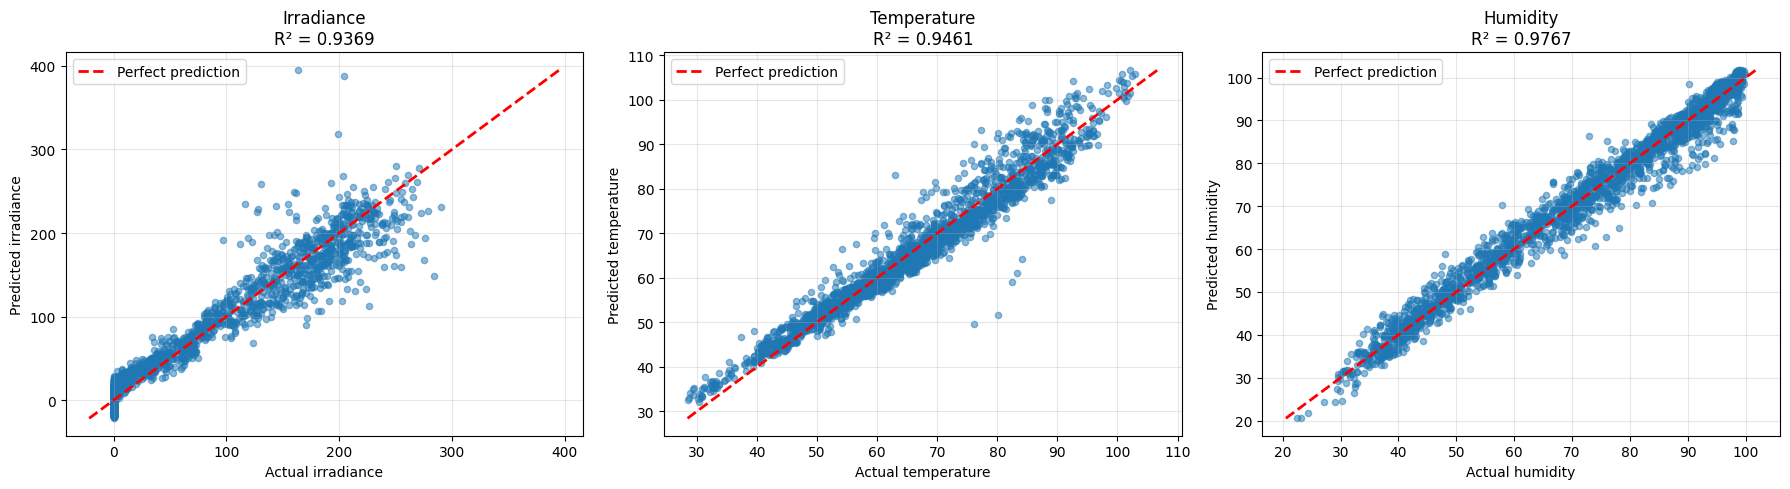

In [33]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, target_name in enumerate(target_cols):
    ax = axes[i]
    
    # Scatter plot: actual vs predicted
    ax.scatter(y_test[:, i], y_test_pred[:, i], alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_test[:, i].min(), y_test_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_test_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    ax.set_xlabel(f'Actual {target_name}')
    ax.set_ylabel(f'Predicted {target_name}')
    ax.set_title(f'{target_name.capitalize()}\nR² = {r2_score(y_test[:, i], y_test_pred[:, i]):.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


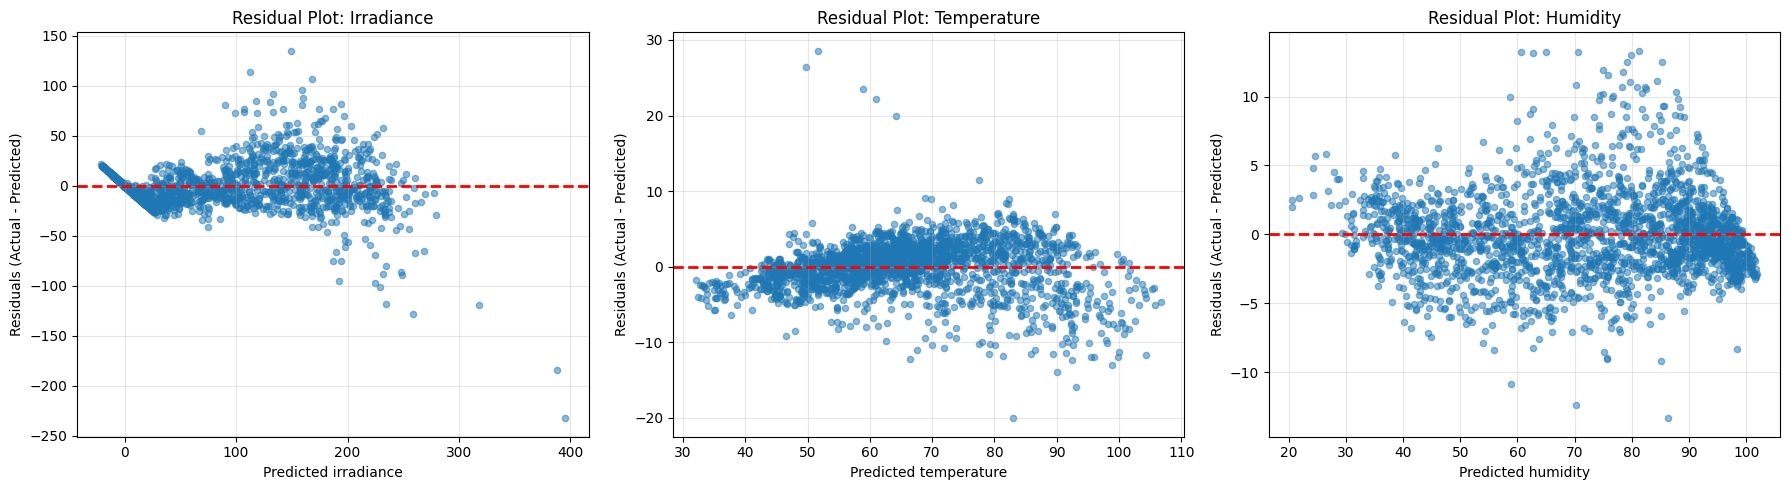

In [34]:
# Plot residuals for each output
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, target_name in enumerate(target_cols):
    ax = axes[i]
    
    residuals = y_test[:, i] - y_test_pred[:, i]
    ax.scatter(y_test_pred[:, i], residuals, alpha=0.5, s=20)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel(f'Predicted {target_name}')
    ax.set_ylabel('Residuals (Actual - Predicted)')
    ax.set_title(f'Residual Plot: {target_name.capitalize()}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


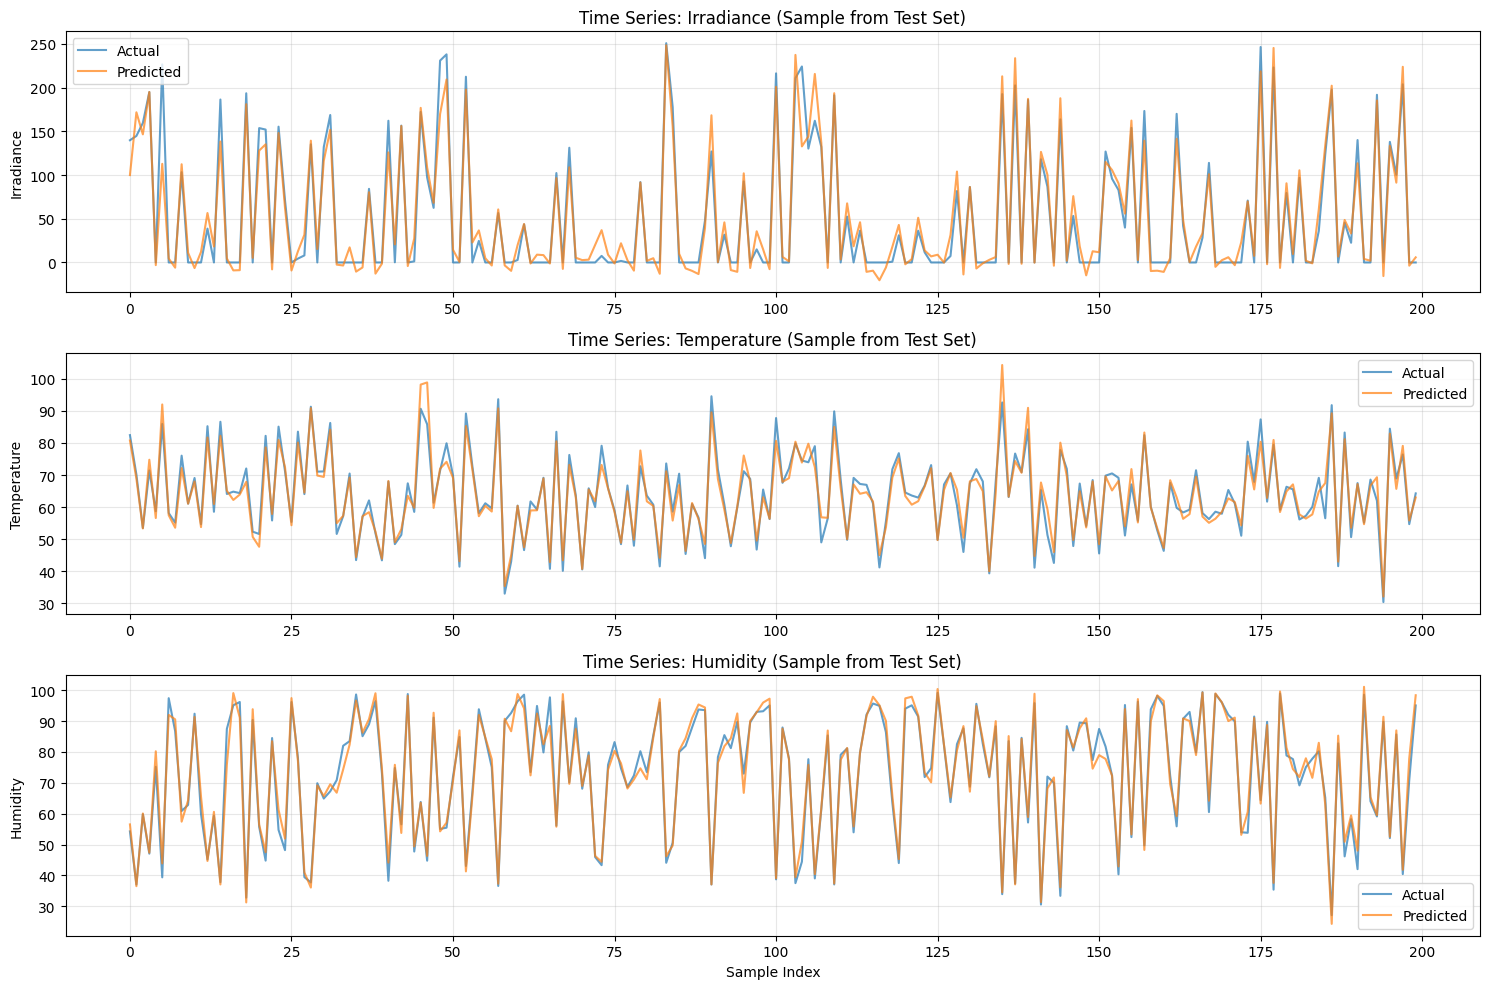

In [35]:
# Time series plot: actual vs predicted for a sample period
# Select a random 200-point window from test set
sample_size = min(200, len(y_test))
start_idx = np.random.randint(0, len(y_test) - sample_size)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, target_name in enumerate(target_cols):
    ax = axes[i]
    
    x_range = range(sample_size)
    ax.plot(x_range, y_test[start_idx:start_idx+sample_size, i], 
            label='Actual', alpha=0.7, linewidth=1.5)
    ax.plot(x_range, y_test_pred[start_idx:start_idx+sample_size, i], 
            label='Predicted', alpha=0.7, linewidth=1.5)
    
    ax.set_ylabel(target_name.capitalize())
    ax.set_title(f'Time Series: {target_name.capitalize()} (Sample from Test Set)')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Sample Index')
plt.tight_layout()
plt.show()
